In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from ast import literal_eval

<b>DATA IMPORTS</b>

In [2]:
current_empl_17_threedigi = pd.read_csv('C:/Users/jbachlombardo/Documents/Community Colleges/Data/College scorecard/CollegeScorecard_Raw_Data/agged_empl_wages_by_county_THREE DIGIT_2.csv')

In [3]:
six_dig_naics = pd.read_csv('C:/Users/jbachlombardo/Documents/Community Colleges/Data/CIP NAICS Crosswalk_THREE DIGIT_2.csv')

In [4]:
naicscodes = [int(x) for x in six_dig_naics[['NAICS Code', 'NAICS Title']].drop_duplicates().dropna()['NAICS Code']]
naicstitles = list(six_dig_naics[['NAICS Code', 'NAICS Title']].drop_duplicates().dropna()['NAICS Title'])
naics_codes_to_titles = dict(zip(naicscodes, naicstitles))

In [5]:
unitid_degs_sixdig = pd.read_csv('C:/Users/jbachlombardo/Documents/Community Colleges/Data/IPEDS/six_deg_ccs_wpercs_no990 051419.csv')

In [75]:
schools = pd.read_csv('C:/Users/jbachlombardo/Documents/Community Colleges/Data/College scorecard/CollegeScorecard_Raw_Data/merged_all_scorecard_indicators_longitudinal_zips_fipsadj_RESET FROM HERE 051619_adjacent_counties.csv')

In [76]:
schools = schools.replace('NaN', np.nan)

In [77]:
with open('C:/Users/jbachlombardo/Documents/Community Colleges/Data/naics_degree_dictionary_THREEDIGIT_2.pickle', 'rb') as handle:
    naics_deg_dict_THREEDIGIT = pickle.load(handle)

In [229]:
deg_code_to_name = pd.read_excel('C:/Users/jbachlombardo/Documents/Community Colleges/Data/IPEDS/dict c2017_a.xlsx', sheet_name = 'Frequencies')

In [232]:
deg_code_to_name_dict = pd.Series(deg_code_to_name['valuelabel'].values, index = deg_code_to_name['codevalue_noperiod'].values).to_dict()

<b>DEF FUNCTIONS</b>

In [135]:
def one_county(s, df_schools = schools, df_employ = current_empl_17_threedigi, df_sixdig_degs = unitid_degs_sixdig, deg_dict = naics_deg_dict_THREEDIGIT, codes_titles_dict = naics_codes_to_titles) :
    #PREP
    school = df_schools.loc[df_schools['UNITID'] == s]
    fips = school['FIPS'].item()
    county = df_employ.loc[df_employ['FIPS'] == fips]
    school_degs = school.merge(df_sixdig_degs, on = 'UNITID')
    county['annual_avg_emplvl_%'] = county['annual_avg_emplvl'] / county['annual_avg_emplvl'].sum()
    nonzero_jobs = list(county[county['annual_avg_emplvl'] > 0]['industry_code'].unique())
    #CALCS
    school_cols = list(school_degs.columns)
    jobs_for_df = list()
    employment_for_df_total = list()
    employment_for_df_perc = list()
    degs_in_job_for_df = list()
    for j in nonzero_jobs :
        deg_list_cc_total = list()
        deg_list_cc_perc = list()
        for d in deg_dict[j] :
            if str(int(d)) in school_cols :
                deg_list_cc_total.append(str(int(d)))
                deg_list_cc_perc.append(str(int(d)) + '_%')
        degs_produced_total = school_degs[deg_list_cc_total].sum(axis = 1).item()
        degs_produced_perc = school_degs[deg_list_cc_perc].sum(axis = 1).item()
        makeup_deg_list = [deg for deg in school_degs[deg_list_cc_total].dropna(axis = 1).columns]
        jobs_for_df.append(j)
        employment_for_df_total.append(degs_produced_total)
        employment_for_df_perc.append(degs_produced_perc)
        degs_in_job_for_df.append(makeup_deg_list)
    #CLEANUP
    job_comps = pd.DataFrame(data = {'NAICS Job Category': jobs_for_df, 'Total filled': employment_for_df_total, '% filled': employment_for_df_perc, 'Degrees makeup': degs_in_job_for_df})
    job_comps = job_comps.set_index('NAICS Job Category').merge(county[['industry_code', 'annual_avg_emplvl', 'annual_avg_emplvl_%']].set_index('industry_code'), left_index = True, right_index = True)
    job_comps['% surplus'] = job_comps['% filled'] - job_comps['annual_avg_emplvl_%']
    job_comps['Total surplus'] = job_comps['Total filled'] - job_comps['annual_avg_emplvl']
    job_comps['UNITID'] = s
    job_comps = job_comps.reset_index().set_index('UNITID').rename(columns = {'index': 'NAICS Job Category'})
    job_comps['NAICS Job Name'] = job_comps['NAICS Job Category'].map(codes_titles_dict)
    
    return job_comps

In [136]:
def multiple_counties(s, df_schools = schools, df_employ = current_empl_17_threedigi, df_sixdig_degs = unitid_degs_sixdig, deg_dict = naics_deg_dict_THREEDIGIT, codes_titles_dict = naics_codes_to_titles) :
    #PREP
    school = df_schools.loc[df_schools['UNITID'] == s]
    counties_fips = literal_eval(schools.loc[schools['UNITID'] == s, 'ADJ_COUNTIES_SCHOOLONLY'].item())
    school_degs = school.merge(df_sixdig_degs, on = 'UNITID')
    counties = df_employ.loc[df_employ['FIPS'].isin(counties_fips)]
    grouped_counties = counties.groupby('industry_code', as_index = False)['annual_avg_emplvl'].sum()
    grouped_counties['annual_avg_emplvl_%'] = grouped_counties['annual_avg_emplvl'] / grouped_counties['annual_avg_emplvl'].sum()
    nonzero_jobs = list(grouped_counties[grouped_counties['annual_avg_emplvl'] > 0]['industry_code'].unique())
    #CALCS
    school_cols = list(school_degs.columns)
    jobs_for_df = list()
    employment_for_df_total = list()
    employment_for_df_perc = list()
    degs_in_job_for_df = list()
    for j in nonzero_jobs :
        deg_list_cc_total = list()
        deg_list_cc_perc = list()
        for d in deg_dict[j] :
            if str(int(d)) in school_cols :
                deg_list_cc_total.append(str(int(d)))
                deg_list_cc_perc.append(str(int(d)) + '_%')
        degs_produced_total = school_degs[deg_list_cc_total].sum(axis = 1).item()
        degs_produced_perc = school_degs[deg_list_cc_perc].sum(axis = 1).item()
        makeup_deg_list = [deg for deg in school_degs[deg_list_cc_total].dropna(axis = 1).columns]
        jobs_for_df.append(j)
        employment_for_df_total.append(degs_produced_total)
        employment_for_df_perc.append(degs_produced_perc)
        degs_in_job_for_df.append(makeup_deg_list)
    #CLEANUP
    job_comps = pd.DataFrame(data = {'NAICS Job Category': jobs_for_df, 'Total filled': employment_for_df_total, '% filled': employment_for_df_perc, 'Degrees makeup': degs_in_job_for_df})
    job_comps = job_comps.set_index('NAICS Job Category').merge(grouped_counties[['industry_code', 'annual_avg_emplvl', 'annual_avg_emplvl_%']].set_index('industry_code'), left_index = True, right_index = True)
    job_comps['% surplus'] = job_comps['% filled'] - job_comps['annual_avg_emplvl_%']
    job_comps['Total surplus'] = job_comps['Total filled'] - job_comps['annual_avg_emplvl']
    job_comps['UNITID'] = s
    job_comps = job_comps.reset_index().set_index('UNITID').rename(columns = {'index': 'NAICS Job Category'})
    job_comps['NAICS Job Name'] = job_comps['NAICS Job Category'].map(codes_titles_dict)
  
    return job_comps

In [137]:
def get_leftover_degs(s, df_job_comps, df_sixdig_degs = unitid_degs_sixdig) :
    used = list()
    for degs in df_job_comps['Degrees makeup'] :
        if len(degs) > 0 :
            for d in degs :
                if d in used :
                    continue
                else :
                    used.append(d)
    leftover = [c for c in df_sixdig_degs.set_index('UNITID').loc[s].dropna().index if '_%' not in c and c not in used]
    leftover_percs = leftover.copy()
    for l in leftover :
        leftover_percs.append(str(l) + '_%')
    leftover_df = df_sixdig_degs.set_index('UNITID').loc[s][leftover_percs].to_frame().T.reset_index().rename(columns = {'index': 'UNITID'})
    
    return leftover_df

In [152]:
def plot_job_comps(job_comps, deg_dict = naics_codes_to_titles, perc = True) :
    if perc == True :
        col = '% surplus'
    else :
        col = 'Total surplus'
    fig, ax = plt.subplots(figsize = (4, 12))
    job_comps.set_index('NAICS Job Name').sort_values(by = col)[col].plot(kind = 'barh')
    ax.set_title(col)
    plt.show()

<b>SLIMMING TO NCES DATASET</b>

In [139]:
unique_schools = list(unitid_degs_sixdig['UNITID'])

In [140]:
schools = schools[schools['UNITID'].isin(unique_schools)]

<b>RUNNING COMPS</b>

In [141]:
job_comps_all = pd.DataFrame()
leftovers_all = pd.DataFrame()

In [142]:
for s in unique_schools :
    if pd.isnull(schools.loc[schools['UNITID'] == s, 'ADJ_COUNTIES_SCHOOLONLY'].item()) :
        job_comps = one_county(s)
    else :
        job_comps = multiple_counties(s)
    leftovers = get_leftover_degs(s, job_comps)
    job_comps_all = pd.concat([job_comps_all, job_comps])
    leftovers_all = pd.concat([leftovers_all, leftovers])

C:\Users\jbachlombardo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  
C:\Users\jbachlombardo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [143]:
leftovers_all = leftovers_all.set_index('UNITID')

In [144]:
leftovers_all['Total leftover'] = leftovers_all[[c for c in leftovers_all.columns if '_%' not in c]].sum(axis = 1)
leftovers_all['Total leftover_%'] = leftovers_all[[c for c in leftovers_all.columns if '_%' in c]].sum(axis = 1)

In [145]:
job_comps_all.to_csv('C:/Users/jbachlombardo/Documents/Community Colleges/Data/job_comps 051619.csv')
leftovers_all.to_csv('C:/Users/jbachlombardo/Documents/Community Colleges/Data/leftovers 051619.csv')

<b>ANALYSIS</b>

In [48]:
def ecdf(data) :
    x = np.sort(data)
    y = np.arange(0,len(x)) / len(x)
    return x, y

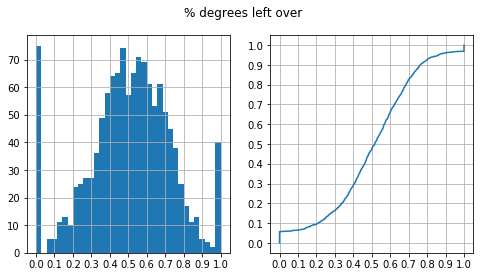

In [91]:
bins = int(np.sqrt(len(leftovers_all))//1)
x, y = ecdf(leftovers_all['Total leftover_%'].values)
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (8, 4))
leftovers_all['Total leftover_%'].hist(bins = bins, ax = ax1)
ax2.plot(x, y)
ax1.set_xticks([x/10 for x in np.arange(0, 11)])
ax2.set_xticks([x/10 for x in np.arange(0, 11)])
ax2.set_yticks([x/10 for x in np.arange(0, 11)])
ax2.grid()
fig.suptitle('% degrees left over')
plt.show()

In [92]:
print ('<50% missing: {:.2f}%'.format((leftovers_all['Total leftover_%']>0.5).sum()/len(leftovers_all)*100))

<50% missing: 52.39%


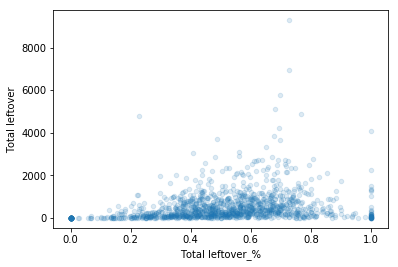

In [93]:
fig, ax = plt.subplots()
leftovers_all.plot.scatter(x = 'Total leftover_%', y = 'Total leftover', ax = ax, alpha = 0.15)
plt.show()

In [94]:
monroecc = 193326

In [95]:
leftovers_all.loc[monroecc].dropna()

110103                 8.000000
110103_%               0.003605
131501                 5.000000
131501_%               0.002253
150303                16.000000
150303_%               0.007210
150304                 8.000000
150304_%               0.003605
150505                 3.000000
150505_%               0.001352
150805                17.000000
150805_%               0.007661
151201                 6.000000
151201_%               0.002704
151302                 3.000000
151302_%               0.001352
240101                30.000000
240101_%               0.013520
240102               727.000000
240102_%               0.327625
270199                14.000000
270199_%               0.006309
302001                 2.000000
302001_%               0.000901
303301                 5.000000
303301_%               0.002253
310302                 1.000000
310302_%               0.000451
400601                 5.000000
400601_%               0.002253
430103                45.000000
430103_%

In [98]:
quarterused = list(leftovers_all[leftovers_all['Total leftover_%'] <= 0.25].index)

In [99]:
investigate = list()
for s in quarterused :
    unique_degs = list()
    for i, degs in job_comps_all.loc[s]['Degrees makeup'].items() :
        for d in degs :
            if d in unique_degs :
                continue
            else :
                unique_degs.append(d)
    if len(unique_degs) > 10 :
        investigate.append(s)
    else :
        continue

In [100]:
for s in investigate :
    if job_comps_all.loc[s][['% surplus', 'Degrees makeup']].sort_values(by = '% surplus').iloc[0,0] < -0.05 :
        print (job_comps_all.loc[s][['% surplus', 'Degrees makeup']].sort_values(by = '% surplus')[:3])

        % surplus                                    Degrees makeup
UNITID                                                             
161688  -0.058574  [513104, 120503, 111003, 521201, 520201, 520302]
161688   0.016965                          [120503, 510805, 520302]
161688   0.044120                          [521201, 470604, 520302]
        % surplus    Degrees makeup
UNITID                             
164313  -0.140313  [520201, 520302]
164313   0.000021  [520201, 520302]
164313   0.008766          [520302]
        % surplus Degrees makeup
UNITID                          
194028  -0.069373       [520201]
194028  -0.027156             []
194028  -0.011171       [430107]
        % surplus                    Degrees makeup
UNITID                                             
203155  -0.096481  [310504, 120503, 520203, 520302]
203155   0.014309          [521299, 520203, 520302]
203155   0.017984  [520203, 521908, 520302, 521299]
        % surplus    Degrees makeup
UNITID             

In [70]:
for s in [123484, 161688, 162122, 434672, 164313, 175643, 194028, 226107] :
    print (round(leftovers_all.loc[s]['Total leftover_%'], 3), '--', leftovers_all.loc[s]['Total leftover'])

0.217 -- 62.0
0.22 -- 148.0
0.239 -- 472.0
0.192 -- 529.0
0.142 -- 79.0
0.146 -- 83.0
0.249 -- 77.0
0.178 -- 57.0


In [123]:
schools.loc[schools['UNITID'] == 226107][['UNITID', 'INSTNM', 'CITY', 'STABBR', 'LOCALE', 'ADJ_SCHOOLS', 'ADJ_COUNTIES_SCHOOLONLY', 'ADJ_FIPS']]

,UNITID,INSTNM,CITY,STABBR,LOCALE,ADJ_SCHOOLS,ADJ_COUNTIES_SCHOOLONLY,ADJ_FIPS
852,226107,Lamar State College-Orange,Orange,TX,22.0,"[226107, 226116, 441760]",NaN,"[48245.0, 48361.0]"


In [113]:
job_comps_all.loc[427991].sort_values('% surplus')

,NAICS Job Category,% filled,Degrees makeup,annual_avg_emplvl,annual_avg_emplvl_%,% surplus,NAICS Job Name
UNITID,,,,,,,
427991,722,0.096059,"[460302, 120503]",12118,0.156489,-0.060429,Food Services and Drinking Places
427991,484,0.000000,[],322,0.004158,-0.004158,Truck Transportation
427991,481,0.000000,[],24,0.000310,-0.000310,Air Transportation
427991,115,0.000000,[],7,0.000090,-0.000090,Support Activities for Agriculture and Forestry
427991,441,0.039409,[470604],1288,0.016633,0.022776,Motor Vehicle and Parts Dealers
427991,492,0.032020,[100303],68,0.000878,0.031142,Couriers and Messengers
427991,519,0.032020,[100303],23,0.000297,0.031723,Other Information Services
427991,485,0.039409,[470604],105,0.001356,0.038053,Transit and Ground Passenger Transportation
427991,236,0.061576,[460302],1793,0.023154,0.038422,Construction of Buildings


In [155]:
school_ids = [175643, 226107, 161688, 164313, 193326, 236887, 118912]

In [160]:
school_ids = list(np.sort(school_ids))

In [177]:
school_ids[6]

236887

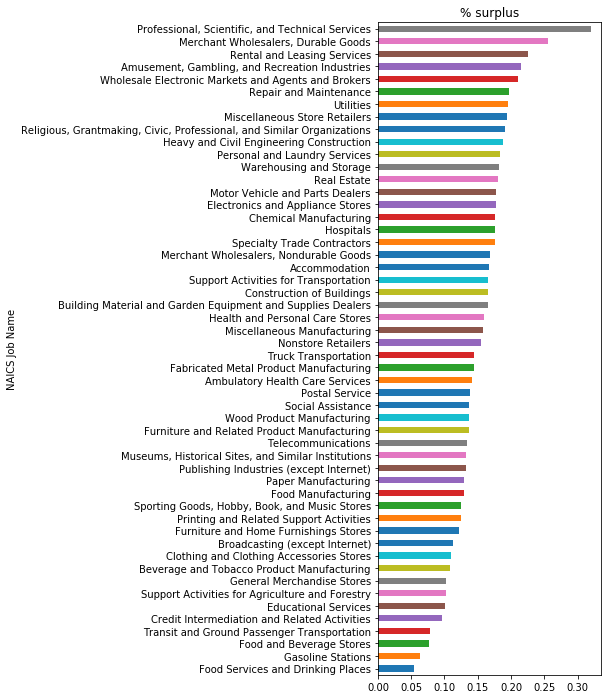

In [178]:
plot_job_comps(job_comps_all.loc[school_ids[6]], perc = True)

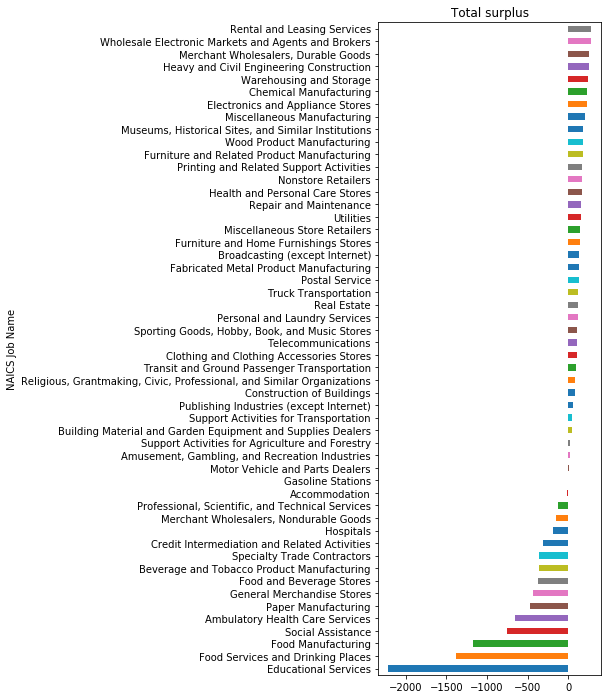

In [179]:
plot_job_comps(job_comps_all.loc[school_ids[6]], perc = False)

In [273]:
id_num = 6
school_ids[id_num]

236887

In [274]:
grabber = schools.set_index('UNITID').loc[school_ids[id_num]]
if pd.isnull(grabber.loc['ADJ_COUNTIES_SCHOOLONLY']) :
    county = int(grabber.loc['FIPS'])
    counties = list()
    counties.append(county)
else :
    counties = literal_eval(grabber.loc['ADJ_COUNTIES_SCHOOLONLY'])

Text(0.5,1,'Total employment (top 25 categories)')

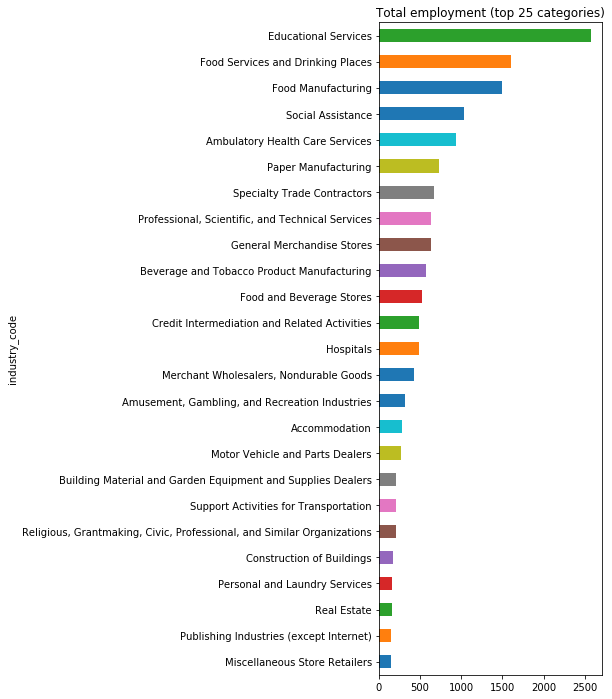

In [275]:
county_grouped = current_empl_17_threedigi.loc[current_empl_17_threedigi['FIPS'].isin(counties)].groupby('industry_code')['annual_avg_emplvl'].sum()
# county_grouped = county_grouped / county_grouped.sum()
county_grouped.index = county_grouped.index.map(naics_codes_to_titles)
fig, ax = plt.subplots(figsize = (4, 12))
county_grouped.sort_values(ascending = True).tail(25).plot(kind = 'barh')
ax.set_title('Total employment (top 25 categories)')

Text(0.5,0,'Count')

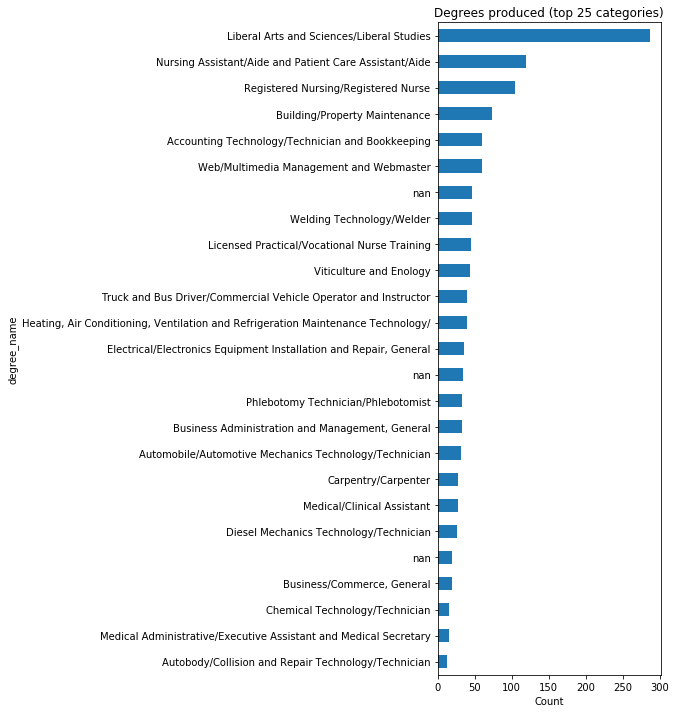

In [276]:
keep_cols = [c for c in unitid_degs_sixdig.set_index('UNITID').columns if '_%' not in c]
degrees_produced = unitid_degs_sixdig.set_index('UNITID').loc[school_ids[id_num]][keep_cols].dropna().reset_index()
degrees_produced.columns = ['degree_number', 'count']
degrees_produced['degree_name'] = degrees_produced['degree_number'].astype(int).map(deg_code_to_name_dict)
fig, ax = plt.subplots(figsize = (4, 12))
degrees_produced.set_index('degree_name').sort_values(by = 'count', ascending = True).tail(25).plot(kind = 'barh', ax = ax, legend = None)
ax.set_title('Degrees produced (top 25 categories)')
ax.set_xlabel('Count')